In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.experimental import (
    enable_iterative_imputer,
)
from sklearn import (
    ensemble,
    impute,
    model_selection,    
    preprocessing,
    tree,
)

url = (
    "http://biostat.mc.vanderbilt.edu/"
    "wiki/pub/Main/DataSets/titanic3.xls"
)
df = pd.read_excel(url)
def tweak_titanic(df):
    df = df.drop(
        columns=[
            "name",
            "ticket",
            "home.dest",
            "boat",
            "body",
            "cabin",
        ]
    ).pipe(pd.get_dummies, drop_first=True)
    return df

def get_train_test_X_y(
    df, y_col, size=0.3, std_cols=None
):
    y = df[y_col]
    X = df.drop(columns=y_col)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=size, random_state=42
    )
    cols = X.columns
    num_cols = [
        "pclass",
        "age",
        "sibsp",
        "parch",
        "fare",
    ]
    fi = impute.IterativeImputer()

    fitted = fi.fit_transform(X_train[num_cols])
    X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(num_cols)})
    test_fit = fi.transform(X_test[num_cols])
    X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(num_cols)})
    if std_cols:
        std = preprocessing.StandardScaler()
        fitted = std.fit_transform(X_train[std_cols])
        X_train = X_train.assign(**{c:fitted[:,i] for i, c in enumerate(std_cols)})
        test_fit = std.transform(X_test[std_cols])
        X_test = X_test.assign(**{c:test_fit[:,i] for i, c in enumerate(std_cols)})

    return X_train, X_test, y_train, y_test

ti_df = tweak_titanic(df)
std_cols = "pclass,age,sibsp,fare".split(",")
X_train, X_test, y_train, y_test = get_train_test_X_y(
    ti_df, "survived", std_cols=std_cols
)

X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])


In [5]:
from sklearn.linear_model import (
    LogisticRegression,
)
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)
lr.predict(X.iloc[[0]])
lr.predict_proba(X.iloc[[0]])
lr.predict_log_proba(X.iloc[[0]])
lr.decision_function(X.iloc[[0]])

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([-2.16531643])

In [6]:
lr.intercept_

array([1.22466932])

In [7]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))
inv_logit(lr.intercept_)

array([0.77288422])

In [8]:
cols = X.columns
for col, val in sorted(
    zip(cols, lr.coef_[0]),
    key=lambda x: x[1],
    reverse=True,
):
    print(
        f"{col:10}{val:10.3f} {inv_logit(val):10.3f}"
    )

fare           0.104      0.526
parch         -0.063      0.484
sibsp         -0.273      0.432
age           -0.295      0.427
embarked_Q    -0.495      0.379
embarked_S    -0.508      0.376
pclass        -0.738      0.323
sex_male      -2.408      0.083


c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\yellowbrick\model_selection\importances.py:195: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


[Text(0.5, 0, 'Względna wielkość współczynnika'),
 Text(0.5, 1.0, 'Ważności 8 cech (regresja logistyczna)')]

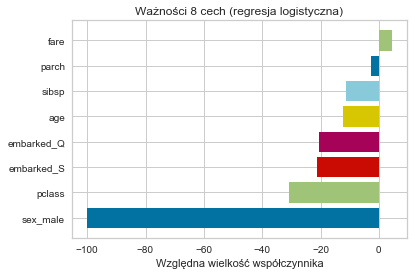

In [9]:
from yellowbrick.features import FeatureImportances
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(lr)
fi_viz.fit(X, y)
fi_viz.ax.set(title="Ważności 8 cech (regresja logistyczna)", xlabel="Względna wielkość współczynnika")
#fig.savefig("images/mlpr_1001.png", dpi=300)

In [10]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)
nb.predict(X.iloc[[0]])
nb.predict_proba(X.iloc[[0]])
nb.predict_log_proba(X.iloc[[0]])

array([[-0.04128744, -3.20776959]])

In [11]:
from sklearn.svm import SVC
svc = SVC(random_state=42, probability=True)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)
svc.predict(X.iloc[[0]])
svc.predict_proba(X.iloc[[0]])
svc.predict_log_proba(X.iloc[[0]])

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([[-0.15822533, -1.92180489]])

In [12]:
from sklearn.neighbors import (
    KNeighborsClassifier,
)
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc.score(X_test, y_test)
knc.predict(X.iloc[[0]])
knc.predict_proba(X.iloc[[0]])

array([[0.8, 0.2]])

In [13]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(
    random_state=42, max_depth=3
)
dt.fit(X_train, y_train)
dt.score(X_test, y_test)
dt.predict(X.iloc[[0]])
dt.predict_proba(X.iloc[[0]])
dt.predict_log_proba(X.iloc[[0]])

array([[-0.12835003, -2.11648281]])

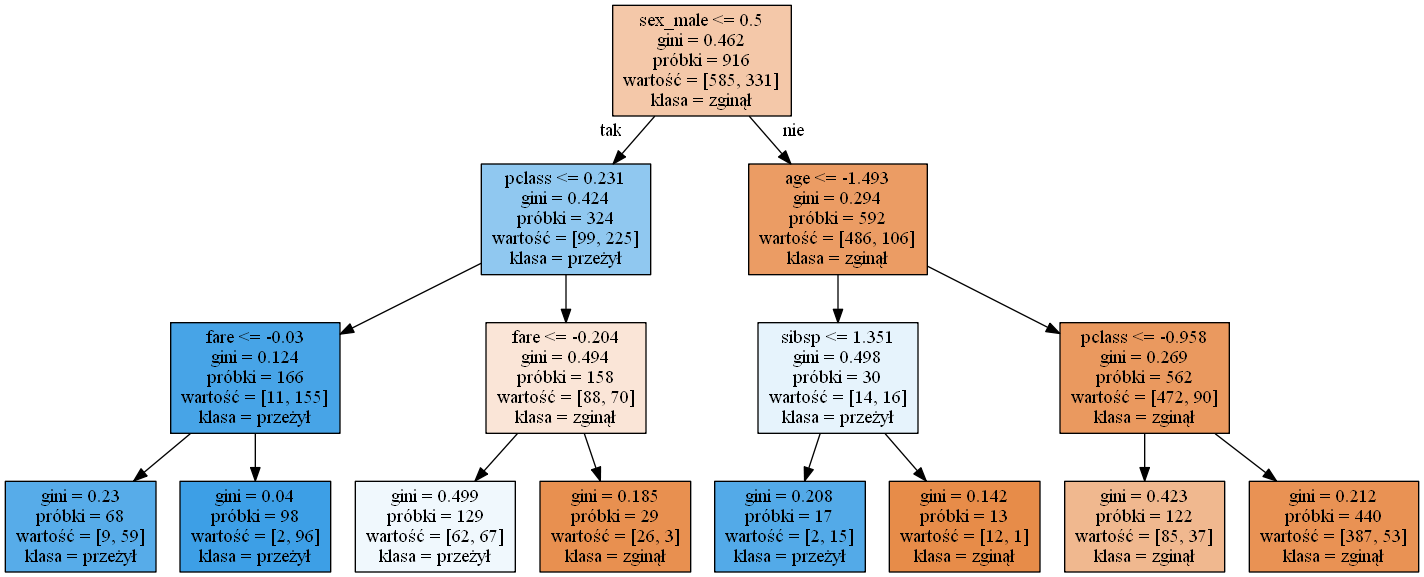

In [32]:
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
dot_data = StringIO()
tree.export_graphviz(
    dt,
    out_file=dot_data,
    feature_names=X.columns,
    class_names=["zginął", "przeżył"],
    filled=True,
)
d = dot_data.getvalue().replace("nsamples", "npróbki") \
                       .replace("nvalue", "nwartość") \
                       .replace("nclass", "nklasa") \
                       .replace("True", "tak") \
                       .replace("False", "nie")
g = pydotplus.graph_from_dot_data(d)
Image(g.create_png())

#g.write_png("images/mlpr_1002.png")

In [38]:
import dtreeviz.trees
viz = dtreeviz.trees.dtreeviz(
    dt,
    X,
    y,
    target_name="cel",
    feature_names=X.columns,
    class_names=["zginął", "przeżył"],
)
viz

In [13]:
for col, val in sorted(
    zip(X.columns, dt.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.607
pclass         0.248
sibsp          0.052
fare           0.050
age            0.043


[Text(0.5, 0, 'Względna ważność'),
 Text(0.5, 1.0, 'Ważność 8 cech (drzewo decyzyjne)')]

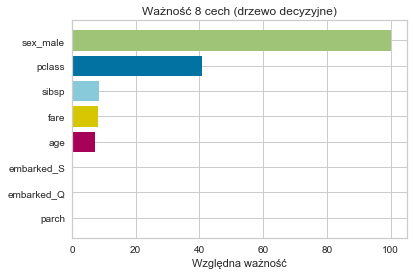

In [40]:
from yellowbrick.features import (
    FeatureImportances,
)
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(dt)
fi_viz.fit(X, y)
fi_viz.ax.set(title="Ważność 8 cech (drzewo decyzyjne)", xlabel = "Względna ważność")
#fig.savefig("images/mlpr_1004.png", dpi=300)

In [16]:
from sklearn.ensemble import (
    RandomForestClassifier,
)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)
rf.predict(X.iloc[[0]])
rf.predict_proba(X.iloc[[0]])
rf.predict_log_proba(X.iloc[[0]])

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:635: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)


array([[  0., -inf]])

In [17]:
for col, val in sorted(
    zip(X.columns, rf.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

age            0.280
fare           0.274
sex_male       0.230
pclass         0.086
sibsp          0.053


In [18]:
import rfpimp
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rfpimp.importances(
    rf, X_test, y_test
).Importance

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Feature
sex_male      0.147583
age           0.040712
fare          0.030534
embarked_S    0.022901
pclass        0.017812
parch         0.012723
embarked_Q    0.007634
sibsp         0.000000
Name: Importance, dtype: float64

In [42]:
import xgboost as xgb
xgb_class = xgb.XGBClassifier(random_state=42)
xgb_class.fit(
    X_train,
    y_train,
    early_stopping_rounds=10,
    eval_set=[(X_test, y_test)],
)
xgb_class.score(X_test, y_test)
xgb_class.predict(X.iloc[[0]])
xgb_class.predict_proba(X.iloc[[0]])

[0]	validation_0-error:0.188295
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.188295
[2]	validation_0-error:0.188295
[3]	validation_0-error:0.188295
[4]	validation_0-error:0.188295
[5]	validation_0-error:0.188295
[6]	validation_0-error:0.203562
[7]	validation_0-error:0.203562
[8]	validation_0-error:0.203562
[9]	validation_0-error:0.203562
[10]	validation_0-error:0.203562
Stopping. Best iteration:
[0]	validation_0-error:0.188295



array([[0.53754187, 0.46245816]], dtype=float32)

In [43]:
for col, val in sorted(
    zip(
        X.columns,
        xgb_class.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex_male       0.665
pclass         0.155
sibsp          0.069
embarked_S     0.042
age            0.038


[Text(0, 0.5, 'Cechy'),
 Text(0.5, 0, 'Ocena F'),
 Text(0.5, 1.0, 'Ważność cechy')]

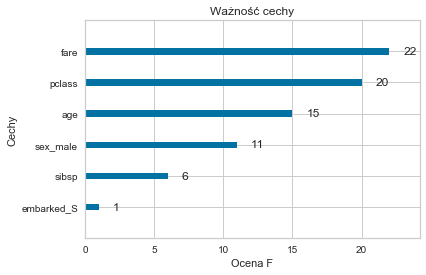

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_importance(xgb_class, ax=ax)
ax.set(title="Ważność cechy", xlabel="Ocena F", ylabel="Cechy")
#fig.savefig("images/mlpr_1005.png", dpi=300)

[Text(0.5, 0, 'Względna ważność'), Text(0.5, 1.0, 'Ważność 8 cech (XGBoost)')]

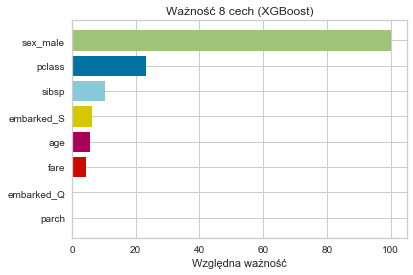

In [47]:
fig, ax = plt.subplots(figsize=(6, 4))
fi_viz = FeatureImportances(xgb_class)
fi_viz.fit(X, y)
fi_viz.ax.set(title="Ważność 8 cech (XGBoost)", xlabel="Względna ważność")
#fig.savefig("images/mlpr_1006.png", dpi=300)

In [48]:
booster = xgb_class.get_booster()
print(booster.get_dump()[0])

0:[sex_male<1] yes=1,no=2,missing=1
	1:[pclass<0.23096557] yes=3,no=4,missing=3
		3:leaf=0.169411764
		4:[fare<-0.203882411] yes=7,no=8,missing=7
			7:leaf=0.00751879672
			8:leaf=-0.139393941
	2:[age<-1.49289274] yes=5,no=6,missing=5
		5:[sibsp<1.35050142] yes=9,no=10,missing=9
			9:leaf=0.123809531
			10:leaf=-0.129411772
		6:[pclass<-0.957598865] yes=11,no=12,missing=11
			11:leaf=-0.0761904791
			12:leaf=-0.150450453



In [49]:
# score from first tree leaf 7
1 / (1 + np.exp(-1 * 0.1238))

0.5309105310475829

<module 'xgboost' from 'c:\\users\\admin\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\xgboost\\__init__.py'>

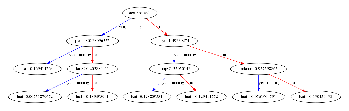

In [57]:
fig, ax = plt.subplots(figsize=(6, 4))
xgb.plot_tree(xgb_class, ax=ax, num_trees=0)
fig.savefig("images/mlpr_1007.png", dpi=300)

In [58]:
import xgbfir
xgbfir.saveXgbFI(
    xgb_class,
    feature_names=X.columns,
    OutputXlsxFile="fir.xlsx",
)
pd.read_excel("fir.xlsx").head(3).T

,0,1,2
Interaction,sex_male,pclass,fare
Gain,1121.64,476.288,101.613
FScore,11,20,22
wFScore,11,9.55336,4.71332
Average wFScore,1,0.477668,0.214242
Average Gain,101.967,23.8144,4.61879
Expected Gain,1121.64,185.931,21.7306
Gain Rank,1,2,3
FScore Rank,4,2,1
wFScore Rank,1,2,4


In [59]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 1",
).head(2).T

,0,1
Interaction,pclass|sex_male,age|sex_male
Gain,1781.13,920.43
FScore,15,6
wFScore,6.48948,3.87153
Average wFScore,0.432632,0.645255
Average Gain,118.742,153.405
Expected Gain,703.414,594.172
Gain Rank,1,2
FScore Rank,2,4
wFScore Rank,1,3


In [60]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 2",
).head(1).T

,0
Interaction,fare|pclass|sex_male
Gain,2516.76
FScore,19
wFScore,3.37555
Average wFScore,0.17766
Average Gain,132.461
Expected Gain,445.008
Gain Rank,1
FScore Rank,1
wFScore Rank,2


In [61]:
pd.read_excel(
    "fir.xlsx",
    sheet_name="Interaction Depth 2",
)[["Interaction", "Gain"]].head()

,Interaction,Gain
0,fare|pclass|sex_male,2516.761191
1,age|pclass|sex_male,1386.095777
2,age|sex_male|sibsp,984.017027
3,age|fare|sex_male,140.219051
4,embarked_S|pclass|sex_male,106.802960


In [62]:
import lightgbm as lgb
lgbm_class = lgb.LGBMClassifier(
    random_state=42
)
lgbm_class.fit(X_train, y_train)
lgbm_class.score(X_test, y_test)
lgbm_class.predict(X.iloc[[0]])
lgbm_class.predict_proba(X.iloc[[0]])

array([[0.98090161, 0.01909839]])

In [63]:
for col, val in sorted(
    zip(cols, lgbm_class.feature_importances_),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

fare        1285.000
age         1198.000
sex_male     113.000
pclass       112.000
sibsp         99.000


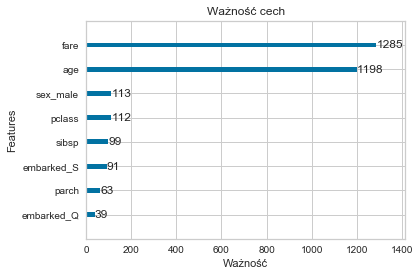

In [77]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_importance(lgbm_class, ax=ax)
ax.set(title="Ważność cech", xlabel="Ważność", ylabel="Cecha")
fig.tight_layout()
#fig.savefig("images/mlpr_1008.png", dpi=300)

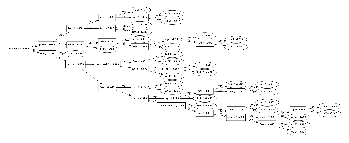

In [75]:
fig, ax = plt.subplots(figsize=(6, 4))
lgb.plot_tree(lgbm_class, tree_index=0, ax=ax)
fig.savefig("images/mlpr_1009.png", dpi=1200)

In [66]:
import janitor as jn
from catboost import CatBoostClassifier
cat_df = df.copy()
cat_df = cat_df.drop(
    [
        "name",
        "ticket",
        "home.dest",
        "boat",
        "body",
        "cabin",
    ],
    axis=1,
)
cat_df = cat_df.fillna(cat_df.median())
cat_df = cat_df.fillna(
    "missing"
)  # for objects
cat_X, cat_y = jn.get_features_targets(
    cat_df, target_columns="survived"
)
X_train3, X_test3, y_train3, y_test3 = model_selection.train_test_split(
    cat_X,
    cat_y,
    test_size=0.3,
    random_state=42,
)
cat_idxs = np.where(cat_X.dtypes == object)[0]
cb = CatBoostClassifier(random_state=42)
cb.fit(
    X_train3,
    y_train3,
    cat_features=cat_idxs,
    plot=True,
)
cb.score(X_test3, y_test3)

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\janitor\utils.py:287: FutureWarning: get_features_targets() has moved. Please use ml.get_features_targets().
  warnings.warn(message, FutureWarning)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.016343
0:	learn: 0.6833543	total: 161ms	remaining: 2m 40s
1:	learn: 0.6740696	total: 168ms	remaining: 1m 23s
2:	learn: 0.6647891	total: 175ms	remaining: 58.3s
3:	learn: 0.6565131	total: 182ms	remaining: 45.3s
4:	learn: 0.6482200	total: 187ms	remaining: 37.2s
5:	learn: 0.6396168	total: 193ms	remaining: 31.9s
6:	learn: 0.6322708	total: 196ms	remaining: 27.8s
7:	learn: 0.6247251	total: 202ms	remaining: 25s
8:	learn: 0.6175287	total: 206ms	remaining: 22.7s
9:	learn: 0.6110557	total: 210ms	remaining: 20.8s
10:	learn: 0.6034686	total: 215ms	remaining: 19.4s
11:	learn: 0.5980934	total: 219ms	remaining: 18.1s
12:	learn: 0.5927492	total: 221ms	remaining: 16.8s
13:	learn: 0.5864883	total: 226ms	remaining: 15.9s
14:	learn: 0.5809311	total: 230ms	remaining: 15.1s
15:	learn: 0.5763103	total: 233ms	remaining: 14.3s
16:	learn: 0.5710223	total: 238ms	remaining: 13.8s
17:	learn: 0.5650739	total: 242ms	remaining: 13.2s
18:	learn: 0.5617135	total: 244ms	remaining: 12.6s
19:	learn: 

0.8040712468193384

In [67]:
for col, val in sorted(
    zip(
        X_test3.columns,
        cb.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:5]:
    print(f"{col:10}{val:10.3f}")

sex           31.690
fare          20.522
age           16.934
pclass        13.026
embarked      10.289


In [68]:
from autosklearn.classification import (
    AutoSklearnClassifier,
)
asc = AutoSklearnClassifier(
    time_left_for_this_task=240
)
asc.fit(X_train, y_train)
asc.score(X_test, y_test)
asc.predict(X.iloc[[0]])
asc.predict_proba(X.iloc[[0]])

ModuleNotFoundError: No module named 'autosklearn'

In [69]:
from tpot import TPOTClassifier
tc = TPOTClassifier(generations=2)
tc.fit(X_train, y_train)
tc.score(X_test, y_test)
tc.predict(X.iloc[[0]])
tc.predict_proba(X.iloc[[0]])

array([[0.82429432, 0.17570568]])

In [44]:
tc.export("tpot_exported_pipeline.py")